# Intro

User-based collaborative filtering is also called user-user collaborative filtering. It is a type of recommendation system algorithm that uses user similarity to make product recommendations.

* Intro to user-based (user-user) collaborative filtering?
* create a user-product matrix?
* process data for user-based collaborative filtering?
* identify similar users?
* narrow down the items pool?
* rank items for the recommendation?
* predict the rating score?
* Calculate pearona correlation and cosine similarity for sample of dataset?


# Step 0: User-Based Collaborative Filtering Recommendation Algorithm

Firstly, let's understand how User-based collaborative filtering works.

User-based collaborative filtering makes recommendations based on user-product interactions in the past. The assumption behind the algorithm is that similar users like similar products.

User-based collaborative filtering algorithm usually has the following steps:

1. Find similar users based on interactions with common items.
2. Identify the items rated high by similar users but have not been exposed to the active user of interest.
3. Calculate the weighted average score for each item.
4. Rank items based on the score and pick top n items to recommend.

# Step 1: Import Python Libraries

In the first step, we will import Python libraries `pandas`, `numpy`, and `scipy.stats`. These three libraries are for data processing and calculations.

We also imported `seaborn` for visualization and `cosine_similarity` for calculating similarity score.

In [1]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Step 2: Download And Read In Data

We Use Noon Electronic Rating using web scraping to collect data for this assignment


In [2]:
# Read in data
ratings=pd.read_excel('C:\\Users\\DELL 5540\\Desktop\\ass\\ratings_Electronics.xlsx')

# Take a look at the data
ratings.head()

,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


There are four columns in the ratings dataset, userID, productID, rating, and timestamp.


In [3]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1048575 non-null  object
 1   productId  1048575 non-null  object
 2   rating     1048575 non-null  int64 
 3   timestamp  1048575 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


The rating has ten unique values from 1 to 5.

In [4]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of product
print('The ratings dataset has', ratings['productId'].nunique(), 'unique products')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 786329 unique users
The ratings dataset has 61893 unique products
The ratings dataset has 5 unique ratings
The unique ratings are [1, 2, 3, 4, 5]


Next, let's read in the products data to get the product names.

The products dataset has productID, title, and genres.

In [5]:
# Define df to be the same as ratings
df = ratings

# Take a look at the data
df.head()


,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


# Step 3: Exploratory Data Analysis (EDA)

In step 3, we need to filter the products and keep only those with over 100 ratings for the analysis.

To do that, we first group the products by title, count the number of ratings, and keep only the products with greater than 100 ratings.

The average ratings for the products are calculated as well.

From the `.info()` output, we can see that there are 1777 products left.

In [6]:
# Aggregate by productId
agg_ratings = df.groupby('productId').agg(mean_rating=('rating', 'mean'),
                                          number_of_ratings=('rating', 'count')).reset_index()

# Keep the products with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings'] > 100]

# Take a look at the data
agg_ratings_GT100.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1777 entries, 34 to 61891
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   productId          1777 non-null   object 
 1   mean_rating        1777 non-null   float64
 2   number_of_ratings  1777 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 55.5+ KB


Let's check what the most popular products and their ratings are.

In [7]:
# Check popular productsش
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,productId,mean_rating,number_of_ratings
30275,B0002L5R78,4.448614,9487
24438,B0001FTVEK,4.007109,5345
61284,B000I68BD4,3.501530,4903
46503,B000BQ7GW8,4.553216,4275
14182,B00007E7JU,4.565995,3523


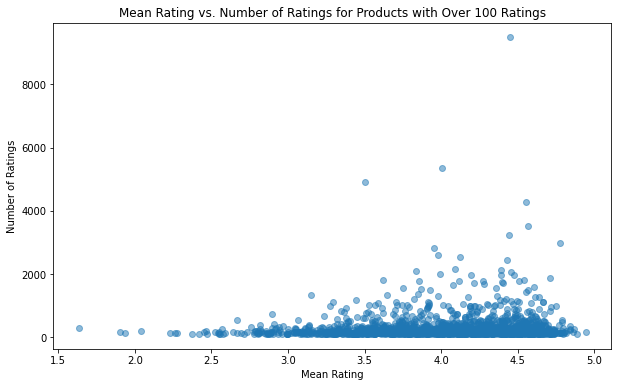

In [8]:
import matplotlib.pyplot as plt

# Scatter plot for mean_rating vs. number_of_ratings
plt.figure(figsize=(10, 6))
plt.scatter(agg_ratings_GT100['mean_rating'], agg_ratings_GT100['number_of_ratings'], alpha=0.5)
plt.xlabel('Mean Rating')
plt.ylabel('Number of Ratings')
plt.title('Mean Rating vs. Number of Ratings for Products with Over 100 Ratings')
plt.show()


To keep only the 1777 products with more than 100 ratings, we need to join the product with the user-rating level dataframe.

`how='inner'` and `on='productId'` ensure that only the products with more than 100 ratings are included.

In [9]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['productId']], on='productId', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536672 entries, 0 to 536671
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     536672 non-null  object
 1   productId  536672 non-null  object
 2   rating     536672 non-null  int64 
 3   timestamp  536672 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 16.4+ MB


After filtering the products with over 100 ratings, we have 452440  users that rated 1777  products.

In [10]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of products
print('The ratings dataset has', df_GT100['productId'].nunique(), 'unique products')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 452440 unique users
The ratings dataset has 1777 unique products
The ratings dataset has 5 unique ratings
The unique ratings are [1, 2, 3, 4, 5]


# Step 4: Create User-product Matrix

In step 4, we will transform the dataset into a matrix format. The rows of the matrix are users, and the columns of the matrix are products. The value of the matrix is the user rating of the product if there is a rating. Otherwise, it shows 'NaN'.

In [11]:
# Filter users with more than a specified number of ratings
user_counts = df['userId'].value_counts()
filtered_users = user_counts[user_counts > 20].index  # Adjust threshold as needed
df_filtered = df[df['userId'].isin(filtered_users)]

# Create the user-item matrix from the filtered DataFrame
matrix = df_filtered.pivot_table(index='userId', columns='productId', values='rating')


In [12]:
matrix.head()


productId,970407998,972683275,1400532655,1400599997,1400699169,1685560148,9043413585,9981719005,9985734459,140053271X,...,B000ID6DTG,B000ID7QNI,B000IDCDZY,B000IDWDKO,B000IE1KZC,B000IE5XIC,B000IE8Z4Q,B000IEVASY,B000IF4788,B000IF51UQ
userId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A101OAAMZYWQ3U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10Y058K7B96C6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11D1KHM7DVOQK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11ED8O95W2103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 5: Data Normalization

Since some people tend to give a higher rating than others, we normalize the rating by extracting the average rating of each user.

After normalization, the products with a rating less than the user's average rating get a negative value, and the products with a rating more than the user's average rating get a positive value.

In [13]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

productId,970407998,972683275,1400532655,1400599997,1400699169,1685560148,9043413585,9981719005,9985734459,140053271X,...,B000ID6DTG,B000ID7QNI,B000IDCDZY,B000IDWDKO,B000IE1KZC,B000IE5XIC,B000IE8Z4Q,B000IEVASY,B000IF4788,B000IF51UQ
userId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A101OAAMZYWQ3U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10Y058K7B96C6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11D1KHM7DVOQK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11ED8O95W2103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 6: Identify Similar Users

There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

we will calculate the user similarity matrix using Pearson correlation.

In [21]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,A100WO06OQR8BQ,A101OAAMZYWQ3U,A10Y058K7B96C6,A11D1KHM7DVOQK,A11ED8O95W2103,A11EYMH9UV9XG7,A11KZ906QD08C5,A12DLJESJKM1OQ,A141OPVE376YFI,A1435P5AMCPB3X,...,AVSMRPI23DQI2,AWJWCKB92RJX2,AWP9CQBB3882G,AWPODHOB4GFWL,AWZR0O65DL2Q,AXARTAQU05PFL,AY8Q1X7G96HV5,AYMD77ITD15PT,AZ0SIZRQWN7RC,AZ515FFZ7I2P7
userId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A101OAAMZYWQ3U,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10Y058K7B96C6,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11D1KHM7DVOQK,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
A11ED8O95W2103,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


for cosine similarity we can refer to this code. Since `cosine_similarity` does not take missing values, we need to impute the missing values with 0s before the calculation.

In [22]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[1.        , 0.        , 0.02119184, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02119184, 0.        , 1.        , ..., 0.16726772, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.16726772, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

Now let's use user ID 'A100WO06OQR8BQ' as an example to illustrate how to find similar users.

We first need to exclude user ID 'A100WO06OQR8BQ' from the similar user list and decide the number of similar users.



In [23]:
# Pick a user ID
picked_userid = 'A100WO06OQR8BQ'

# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity.head()

userId,A100WO06OQR8BQ,A101OAAMZYWQ3U,A10Y058K7B96C6,A11D1KHM7DVOQK,A11ED8O95W2103,A11EYMH9UV9XG7,A11KZ906QD08C5,A12DLJESJKM1OQ,A141OPVE376YFI,A1435P5AMCPB3X,...,AVSMRPI23DQI2,AWJWCKB92RJX2,AWP9CQBB3882G,AWPODHOB4GFWL,AWZR0O65DL2Q,AXARTAQU05PFL,AY8Q1X7G96HV5,AYMD77ITD15PT,AZ0SIZRQWN7RC,AZ515FFZ7I2P7
userId,,,,,,,,,,,,,,,,,,,,,
A101OAAMZYWQ3U,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10Y058K7B96C6,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11D1KHM7DVOQK,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
A11ED8O95W2103,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11EYMH9UV9XG7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the user similarity matrix, the values range from -1 to 1, where -1 means opposite product preference and 1 means same product preference.

`n = 10` means we would like to pick the top 10 most similar users for user ID 'A100WO06OQR8BQ'.

The user-based collaborative filtering makes recommendations based on users with similar tastes, so we need to set a positive threshold. Here we set the `user_similarity_threshold` to be 0.3, meaning that a user must have a Pearson correlation coefficient of at least 0.3 to be considered as a similar user.

After setting the number of similar users and similarity threshold, we sort the user similarity value from the highest and lowest, then printed out the most similar users' ID and the Pearson correlation value.



In [24]:
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user A100WO06OQR8BQ are userId
A1X1CEGHTHMBL1    1.0
A3OXHLG6DIBRW8    1.0
A6FIAB28IS79      1.0
Name: A100WO06OQR8BQ, dtype: float64


# Step 7: Narrow Down Item Pool

In step 7, we will narrow down the item pool by doing the following:
1. Remove the products that have been watched by the target user (user ID 'A100WO06OQR8BQ' in this example).
2. Keep only the products that similar users have watched.

To remove the products watched by the target user, we keep only the row for `userId=A100WO06OQR8BQ` in the user-item matrix and remove the items with missing values.

In [ ]:
# products that the target user has rated
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

productId,B00002EQCW,B00004TDRH,B00006BBAC,B00006HSYC,B00006RVPW,B00007CW52,B00007CW54,B0000AE6G9,B00016BYHQ,B00016V3VI,...,B0002D05RI,B0002L5R78,B0002LEMWE,B0002R5Y5M,B00030DEQE,B0009YJXMS,B000E1HXL4,B000EGJTL6,B000EI3W8U,B000HPV3RW
userId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,1.095238,1.095238,1.095238,1.095238,1.095238,1.095238,1.095238,1.095238,-0.904762,-2.904762,...,-2.904762,-2.904762,0.095238,-2.904762,1.095238,0.095238,0.095238,1.095238,-0.904762,1.095238


To keep only the similar users' products, we keep the user IDs in the top 10 similar user lists and remove the product with all missing values. All missing value for a product means that none of the similar users have watched the product.


In [26]:
# products that similar users watched. Remove products that none of the similar users have watched
similar_user_products = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_products

productId,B00000J05A,B00000J1UQ,B00000J4CY,B00000JHX1,B00000JLSJ,B00001P4X5,B00001P4ZH,B00001W0DI,B000023VUL,B000026D8E,...,B000HGQJZW,B000HGSL4E,B000HPV3RW,B000HXNF8O,B000HZD2XK,B000HZD2YE,B000I20BBI,B000I5HE38,B000I97FJ2,B000I98ZYG
userId,,,,,,,,,,,,,,,,,,,,,
A1X1CEGHTHMBL1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.56,NaN,NaN
A3OXHLG6DIBRW8,NaN,NaN,NaN,-0.421053,0.578947,NaN,NaN,NaN,NaN,-2.421053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.421053,NaN
A6FIAB28IS79,-1.136986,0.863014,-1.136986,NaN,NaN,-1.136986,-1.136986,0.863014,-2.136986,NaN,...,0.863014,0.863014,-0.136986,-0.136986,0.863014,-0.136986,0.863014,NaN,NaN,0.863014


Next, we will drop the products that user ID A100WO06OQR8BQ watched from the similar user product list. `errors='ignore'` drops columns if they exist without giving an error message.

In [27]:
# Remove the watched product from the product list
similar_user_products.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_products

productId,B00000J05A,B00000J1UQ,B00000J4CY,B00000JHX1,B00000JLSJ,B00001P4X5,B00001P4ZH,B00001W0DI,B000023VUL,B000026D8E,...,B000GR1CBI,B000HGQJZW,B000HGSL4E,B000HXNF8O,B000HZD2XK,B000HZD2YE,B000I20BBI,B000I5HE38,B000I97FJ2,B000I98ZYG
userId,,,,,,,,,,,,,,,,,,,,,
A1X1CEGHTHMBL1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.56,NaN,NaN
A3OXHLG6DIBRW8,NaN,NaN,NaN,-0.421053,0.578947,NaN,NaN,NaN,NaN,-2.421053,...,0.578947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.421053,NaN
A6FIAB28IS79,-1.136986,0.863014,-1.136986,NaN,NaN,-1.136986,-1.136986,0.863014,-2.136986,NaN,...,NaN,0.863014,0.863014,-0.136986,0.863014,-0.136986,0.863014,NaN,NaN,0.863014


# Step 8: Recommend Items

In step 8, we will decide which product to recommend to the target user. The recommended items are determined by the weighted average of user similarity score and product rating. The product ratings are weighted by the similarity scores, so the users with higher similarity get higher weights.

This code loops through items and users to get the item score, rank the score from high to low and pick the top 10 products to recommend to user ID A100WO06OQR8BQ.

In [28]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_products.columns:
  # Get the ratings for product i
  product_rating = similar_user_products[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the product has rating
    if pd.isna(product_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the product rating
      score = similar_users[u] * product_rating[u]
      # Add the score to the total score for the product so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['product', 'product_score'])

# Sort the products by score
ranked_item_score = item_score.sort_values(by='product_score', ascending=False)

# Select top m products
m = 10
ranked_item_score.head(m)

,product,product_score
255,B000I98ZYG,0.863014
78,B00007JDR0,0.863014
218,B000EVLS4C,0.863014
107,B0001DBEM4,0.863014
104,B0000UA3MA,0.863014
101,B0000C4DX6,0.863014
96,B00009W3TY,0.863014
92,B00009APE3,0.863014
90,B000094Q77,0.863014
85,B00008N6XJ,0.863014


# Step 9: Predict Scores

If the goal is to choose the recommended items, having the rank of the items is enough. However, if the goal is to predict the user's rating, we need to add the user's average product rating score back to the product score.

In [29]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average product rating for user 1
print(f'The average product rating for user {picked_userid} is {avg_rating:.2f}')

The average product rating for user A100WO06OQR8BQ is 3.90


The average product rating for user 1 is 3.90, so we add 3.90 back to the product score.

In [30]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['product_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)

,product,product_score,predicted_rating
255,B000I98ZYG,0.863014,4.767776
78,B00007JDR0,0.863014,4.767776
218,B000EVLS4C,0.863014,4.767776
107,B0001DBEM4,0.863014,4.767776
104,B0000UA3MA,0.863014,4.767776
101,B0000C4DX6,0.863014,4.767776
96,B00009W3TY,0.863014,4.767776
92,B00009APE3,0.863014,4.767776
90,B000094Q77,0.863014,4.767776
85,B00008N6XJ,0.863014,4.767776


We can see that the top 10 recommended products all have predicted ratings greater than 4.5.

# Step 10: Select Manually sample of dataset to calculate pearsona correlation and cosine similarity for user and item based


In [2]:
import pandas as pd
import numpy as np

# Sample 5x5 User-Item Matrix
data = {
    'item1': [5.0, np.nan, 2.0, 3.0, 3.0],
    'item4': [3.0, 2.0, np.nan, np.nan, np.nan],
    'item2': [4.0, 3.0, 5.0, 3.0, 5.0],
    'item3': [2.0, np.nan, 1.0, np.nan, 4.0],
    'item6': [5.0, 3.0, np.nan, 3.0, 4.0]
}
df = pd.DataFrame(data, index=['user6', 'user7', 'user5', 'user3', 'user8'])

# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    mask = ~np.isnan(vec1) & ~np.isnan(vec2)  # Mask for non-NaN entries
    if mask.sum() == 0:
        return np.nan
    dot_product = np.dot(vec1[mask], vec2[mask])
    norm_a = np.linalg.norm(vec1[mask])
    norm_b = np.linalg.norm(vec2[mask])
    return dot_product / (norm_a * norm_b) if (norm_a * norm_b) != 0 else np.nan

# Function to calculate Pearson correlation
def pearson_correlation(vec1, vec2):
    mask = ~np.isnan(vec1) & ~np.isnan(vec2)  # Mask for non-NaN entries
    if mask.sum() < 2:
        return np.nan  # Pearson requires at least two common ratings
    vec1_centered = vec1[mask] - np.nanmean(vec1[mask])
    vec2_centered = vec2[mask] - np.nanmean(vec2[mask])
    numerator = np.dot(vec1_centered, vec2_centered)
    denominator = np.sqrt(np.dot(vec1_centered, vec1_centered) * np.dot(vec2_centered, vec2_centered))
    return numerator / denominator if denominator != 0 else np.nan

# Calculate item-based similarity
items = df.columns
item_similarity_cosine = pd.DataFrame(index=items, columns=items)
item_similarity_pearson = pd.DataFrame(index=items, columns=items)

for item_a in items:
    for item_b in items:
        if item_a == item_b:
            item_similarity_cosine.loc[item_a, item_b] = 1
            item_similarity_pearson.loc[item_a, item_b] = 1
        else:
            vec1 = df[item_a].values
            vec2 = df[item_b].values
            item_similarity_cosine.loc[item_a, item_b] = cosine_similarity(vec1, vec2)
            item_similarity_pearson.loc[item_a, item_b] = pearson_correlation(vec1, vec2)

# Calculate user-based similarity
users = df.index
user_similarity_cosine = pd.DataFrame(index=users, columns=users)
user_similarity_pearson = pd.DataFrame(index=users, columns=users)

for user_a in users:
    for user_b in users:
        if user_a == user_b:
            user_similarity_cosine.loc[user_a, user_b] = 1
            user_similarity_pearson.loc[user_a, user_b] = 1
        else:
            vec1 = df.loc[user_a].values
            vec2 = df.loc[user_b].values
            user_similarity_cosine.loc[user_a, user_b] = cosine_similarity(vec1, vec2)
            user_similarity_pearson.loc[user_a, user_b] = pearson_correlation(vec1, vec2)

# Display item-based and user-based cosine and Pearson similarity matrices
print("Item-Based Cosine Similarity Matrix:\n", item_similarity_cosine)
print("\nItem-Based Pearson Correlation Matrix:\n", item_similarity_pearson)
print("\nUser-Based Cosine Similarity Matrix:\n", user_similarity_cosine)
print("\nUser-Based Pearson Correlation Matrix:\n", user_similarity_pearson)


Item-Based Cosine Similarity Matrix:
           item1     item4     item2     item3     item6
item1         1       1.0  0.909524  0.849591  0.992062
item4       1.0         1   0.99846       1.0  0.998868
item2  0.909524   0.99846         1  0.886405  0.983051
item3  0.849591       1.0  0.886405         1  0.907959
item6  0.992062  0.998868  0.983051  0.907959         1

Item-Based Pearson Correlation Matrix:
           item1 item4     item2     item3     item6
item1         1   NaN -0.345857  0.142857  0.866025
item4       NaN     1       1.0       NaN       1.0
item2 -0.345857   1.0         1  0.188982  0.636364
item3  0.142857   NaN  0.188982         1      -1.0
item6  0.866025   1.0  0.636364      -1.0         1

User-Based Cosine Similarity Matrix:
           user6     user7     user5     user3     user8
user6         1  0.994987   0.87093  0.994937  0.926872
user7  0.994987         1       1.0       1.0  0.993884
user5   0.87093       1.0         1  0.919145  0.903696
user3  0.9

# Summary

In this assignment, we went over how to build a user-based collaborative filtering recommendation system.
* create a user-product matrix?
* process data for user-based collaborative filtering?
* identify similar users?
* narrow down the items pool?
* rank items for the recommendation?
* predict the rating score?
* Calculate pearona correlation and cosine similarity for sample of dataset?
